In [1]:
using Pkg 
Pkg.activate(".")

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using StableRNGs, GraphPPL,ReactiveMP, RxInfer, Random, Distributions, LinearAlgebra, Plots
using ForwardDiff
using SpecialFunctions, ExponentialAction, DomainSets
using BenchmarkTools
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix  
import ReactiveMP: GaussHermiteCubature, approximate_meancov, InverseWishartMessage
import RxInfer: PointMassFormConstraint, call_boundaries, call_starting_point

In [4]:
#generate data 
function generate_data(n,f_gp, σ_x)
    obs = []
    for i=1:n
        x_t = σ_x * randn() 
        temp = x_t * exp(f_gp[i])
        push!(obs, temp)
    end
    return obs
end

#find natural parameters of Lognormal from mean and variance
function Params2Natural_Lognormal(dist)
    μ,σ = Distributions.params(dist)
    η1 = μ/σ^2 - 1
    η2 = -1 / (2*σ^2)

    return η1, η2
end

#find mean and variance of Lognormal from natural parameters
function Natural2Params_Lognormal(η1, η2)
    μ = -(η1 + 1) / (2*(η2))
    σ = sqrt(-1/(2*(η2)))
    return μ, σ
end

#find the mean of sufficient statistics of lognormal by sampling
function estimate_MeanOfSufficient_Lognormal(dist, func, nsamples)
    samples = rand(StableRNG(1),dist,nsamples)
    Z = sum(func.(samples)) / nsamples
    E_logx = sum(func.(samples) .* log.(samples)) / (nsamples * Z)
    E_logx² = sum(func.(samples) .* (log.(samples)).^2) / (nsamples * Z)
    return E_logx, E_logx²
end

#find the mean of sufficient statistics of lognormal by gausslaguerre
function estimate_MeanOfSufficient_Lognormal_gausslaguerre(dist, func, points, w)
    WeightFunction_Z = (x) -> pdf(dist,x) * func(x) / exp(-x)
    WeightFunction_logx = (x) -> pdf(dist,x) * func(x) * log(x) / exp(-x)
    WeightFunction_logx² = (x) -> pdf(dist,x) * func(x) * (log(x))^2 / exp(-x)

    Z = dot(w,WeightFunction_Z.(points))
    E_logx = clamp(dot(w,WeightFunction_logx.(points)) / Z,tiny,huge)
    E_logx² = clamp(dot(w,WeightFunction_logx².(points)) / Z,tiny,huge)
    return E_logx, E_logx²
end

#find the mean of sufficient statistic of truncated-Normal by gausslaguerre 
function estimate_MeanOfSufficient_Normal_gausslaguerre(sign,dist, func, points, w)
    WeightFunction_Z = (x) -> pdf(dist,x*sign) * func(x*sign) / exp(-x)
    WeightFunction_x = (x) -> sign*pdf(dist,sign*x) * func(sign*x) * x / exp(-x)
    WeightFunction_x² = (x) -> pdf(dist,sign*x) * func(sign*x) * x^2 / exp(-x)

    Z = dot(w,WeightFunction_Z.(points))
    E_x = clamp(dot(w,WeightFunction_x.(points)) / Z,-Inf,huge)
    v = clamp(dot(w,WeightFunction_x².(points)) / Z - E_x^2,tiny,huge)
    return E_x, v
end



estimate_MeanOfSufficient_Normal_gausslaguerre (generic function with 1 method)

In [5]:
laguerre_points, laguerre_w = ReactiveMP.gausslaguerre(150);

In [33]:
σ_c = .5 # true frequency

N = 400; #data length
tmin,tmax = 0., 4.0
time_range = collect(range(tmin, tmax; length=N));

l_amplitude = .7 #true l_gp
σ²_amplitude = 1.

## GP information
meanf = (x) -> 0.0;
kernel(θ) = σ²_amplitude * with_lengthscale(Matern52Kernel(),θ)

Cov_mat = kernelmatrix(kernel(l_amplitude),time_range,time_range) + 1e-8*I;
gp_amplitude = MvNormal(meanf.(time_range), Cov_mat)
amplitude_gt = rand(StableRNG(1133),gp_amplitude)

y_data = generate_data(N,amplitude_gt,σ_c)

slicedim(dim) = (a) -> map(e -> e[dim], a);

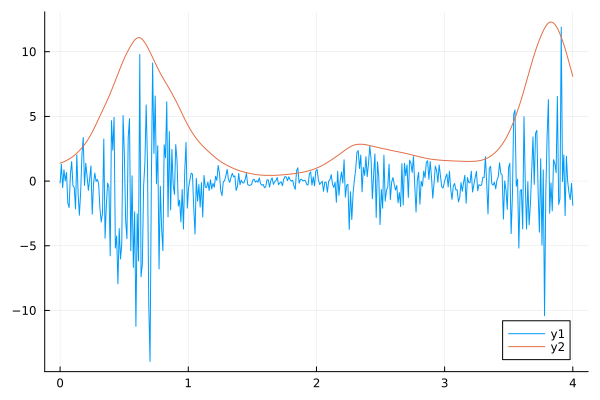

In [34]:
#Generate data 
plot(time_range,y_data)
plot!(time_range,exp.(amplitude_gt))

In [10]:
struct MyExponential end

@node MyExponential Deterministic [ y, x ]   ## x: input,  y: output


@rule MyExponential(:y, Marginalisation) (m_x::UnivariateGaussianDistributionsFamily,) = begin 
    return LogNormal(mean(m_x), sqrt(var(m_x)))
end
@rule MyExponential(:x, Marginalisation) (m_y::LogNormal,) = begin 
    μ, σ = Distributions.params(m_y)
    return NormalMeanVariance(μ - σ^2,σ^2)
end

@marginalrule MyExponential(:x) (m_y::LogNormal, m_x::NormalMeanVariance, ) = begin 
    μ, σ = Distributions.params(m_y)
    mx_out = NormalMeanVariance(μ - σ^2,σ^2) 
    q_x = ReactiveMP.prod(ProdAnalytical(),m_x,mx_out)
    return (x = q_x)
end


In [27]:
Distributions.cov(d::Truncated{Normal{Float64}, Continuous, Float64}) = var(d)
@rule typeof(*)(:A, Marginalisation) (m_out::PointMass, m_A::UnivariateGaussianDistributionsFamily, m_in::LogNormal, meta::TinyCorrection) = begin
    mean_out = mean(m_out) 
    mean_A, var_A = mean_var(m_A)
    if mean_out > 0
        backward_A = (x) -> exp(-log(x + 1e-8) + logpdf(m_in,mean_out/(x)))
        truncated_m_in = TruncatedNormal(mean_A,sqrt(var_A),0.,Inf)
        m,v = estimate_MeanOfSufficient_Normal_gausslaguerre(1,truncated_m_in, backward_A, laguerre_points, laguerre_w)
    else
        backward_A = (x) -> exp(-log(-x -1e-8) + logpdf(m_in,mean_out/(x)))
        truncated_m_in = TruncatedNormal(mean_A,sqrt(var_A),-Inf,0)
        m,v = estimate_MeanOfSufficient_Normal_gausslaguerre(-1,truncated_m_in, backward_A, laguerre_points, laguerre_w)
    end
    ksi = m/v - mean_A/var_A
    precision = clamp(1/v - 1/var_A, tiny,huge)
    return NormalWeightedMeanPrecision(ksi,precision)
end
@rule typeof(*)(:in, Marginalisation) (m_out::PointMass, m_A::UnivariateGaussianDistributionsFamily, m_in::LogNormal, meta::TinyCorrection) = begin 
    backward_in = (x) -> exp(-log(abs(x)+1e-8) + logpdf(m_A,mean(m_out)/x))
    E_logx, E_logx² = estimate_MeanOfSufficient_Lognormal_gausslaguerre(m_in, backward_in, laguerre_points, laguerre_w)
    ## natural parameters of approximated q_in 
    η2_q_in = 1/(2*(E_logx^2 - E_logx²))
    η1_q_in = -2 * η2_q_in * E_logx - 1
    # natural parameters of m_in
    η1_m_in, η2_m_in = Params2Natural_Lognormal(m_in)
    # natural parameters of approximated backward message m_in
    η1_backwardmess = η1_q_in - η1_m_in
    η2_backwardmess = η2_q_in - η2_m_in
    if η2_backwardmess > 0
        η1_backwardmess = η1_m_in 
        η2_backwardmess = η2_m_in 
    end
    # parameters of approximated backward message m_in 
    μ, σ =  Natural2Params_Lognormal(η1_backwardmess, η2_backwardmess)
    return LogNormal(μ, σ)
end
@marginalrule typeof(*)(:A_in) (m_out::PointMass, m_A::UnivariateGaussianDistributionsFamily, m_in::LogNormal, meta::TinyCorrection) = begin 
    b_A = @call_rule typeof(*)(:A, Marginalisation) (m_out = m_out, m_A = m_A, m_in=m_in, meta=meta)
    q_A = ReactiveMP.prod(ProdAnalytical(), b_A, m_A)

    b_in = @call_rule typeof(*)(:in, Marginalisation) (m_out = m_out, m_A = m_A, m_in = m_in, meta=meta)
    q_in = ReactiveMP.prod(ProdAnalytical(),b_in,m_in)
    return (A = q_A,in = q_in, out=m_out)
end


In [12]:
function ReactiveMP.prod(::ProdAnalytical, left::LogNormal, right::LogNormal)
    η1_left, η2_left = Params2Natural_Lognormal(left)
    η1_right, η2_right = Params2Natural_Lognormal(right)

    η1 = η1_left + η1_right
    η2 = η2_left + η2_right 

    μ, σ = Natural2Params_Lognormal(η1,η2)
    return LogNormal(μ,σ)
end

In [13]:
#GP Amplitude Demodulation model 
@model function gp_AmplitudeDemodulation(n,P∞,A,Q,H)
    y = datavar(Float64,n)
    f = randomvar(n)
    z = randomvar(n)
    g = randomvar(n)
    c = randomvar(n)
    # w = randomvar(n)
    
    f_0 ~ MvNormalMeanCovariance(zeros(length(H)), P∞)
    f_prev = f_0
    for i=1:n 
        f[i] ~ MvNormalMeanCovariance(A[i] * f_prev, Q[i])
        z[i] ~ NormalMeanVariance(dot(H , f[i]), 0.01)

        g[i] ~ MyExponential(z[i]) 
        c[i] ~ NormalMeanPrecision(0.0,1/(σ_c)^2) 
        y[i] ~ (*)(c[i],g[i]) where {meta = TinyCorrection(), pipeline = RequireMessage(A = NormalMeanPrecision(0., 10.),in = LogNormal(0,4.))}

        f_prev = f[i]
    end
end

In [35]:
#### compute matrices for the state-space model corresponding to Matern-52 kernel ######
θ = [l_amplitude, σ²_amplitude]; # store [l, σ²]
Δt = [time_range[2] - time_range[1]]; # time difference
append!(Δt, time_range[2:end] - time_range[1:end-1]);

λ = sqrt(5)/θ[1];

L = [0., 0., 1.];
H = [1., 0., 0.];
F = [0. 1. 0.; 0. 0. 1.;-λ^3 -3λ^2 -3λ]
Qc = 16/3 * θ[2] * λ^5;

Imat = diageye(3) ; 
vec_P = inv(kron(Imat,F) + kron(F,Imat)) * vec(-L * Qc * L'); 
P∞ = reshape(vec_P,3,3);
A = [exp(F * i) for i in Δt]; 
Q = [P∞ - i*P∞*i' for i in A];

In [36]:
nits =50

iresult = inference(
    model = gp_AmplitudeDemodulation(length(y_data), P∞,A,Q,H),
    iterations = nits, 
    data  = (y = y_data,),
    returnvars = (f = KeepLast(), ),
    options = (limit_stack_depth=100,),
    free_energy = true,
    showprogress = false
)

Inference results:
  Posteriors       | available for (f)
  Free Energy:     | Real[1446.49, 1252.55, 1551.86, 1598.51, 1622.09, 1619.06, 1617.43, 1616.43, 1616.04, 1616.3  …  1624.11, 1624.71, 1625.52, 1626.14, 1626.49, 1627.81, 1626.38, 1625.91, 1626.05, 1626.7]


In [37]:
mgp = mean.(iresult.posteriors[:f]) |> slicedim(1)
vgp = var.(iresult.posteriors[:f]) |> slicedim(1)
expvgp = exp.( mgp .+ vgp)
expmgp = exp.(mgp);



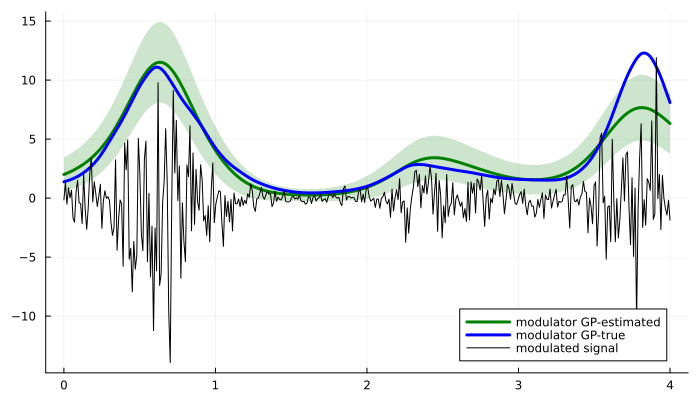

In [40]:
plot(time_range,expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="modulator GP-estimated",fillalpha=0.2,color=:green, size = (700, 400))
plot!(time_range,exp.(amplitude_gt), label="modulator GP-true",linewidth=3.0,color=:blue)
plot!(time_range, y_data, color=:black,label = "modulated signal")

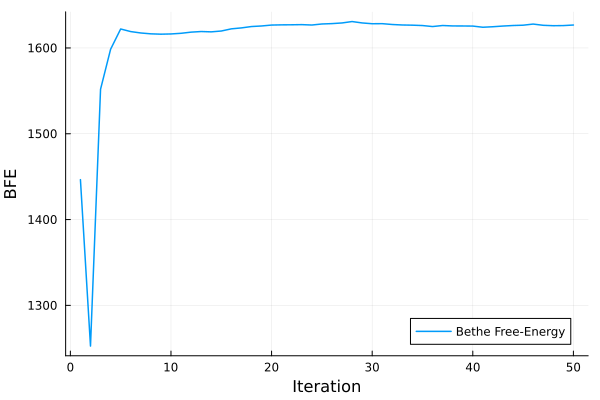

In [41]:
plot(iresult.free_energy, lw=1.5, label="Bethe Free-Energy")
xlabel!("Iteration")
ylabel!("BFE")

## Use Real data 

In [42]:
using WAV, MAT

In [43]:
datapath = "/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/data/"
file = matopen(datapath*"filter_outputs.mat")
FilteredOutput = read(file, "data")

X, fs = wavread(datapath*"data_05-Bubblingstream.wav");
fs = Float64(fs);

In [44]:
data = FilteredOutput[:,2];
NumberOfSamples = length(data);
signal_time = 1/fs * (NumberOfSamples-1);
signaltime_range = collect(0.:1/fs:signal_time); 
data = data / sqrt(var(data));

# #Let's use 1 second of the signal 
NumberOfTruncatedSignalSamples = Int(round(fs+1))
y_data = data[1:NumberOfTruncatedSignalSamples] 
t_data = collect(0.:1/fs:(NumberOfTruncatedSignalSamples-1) / fs);

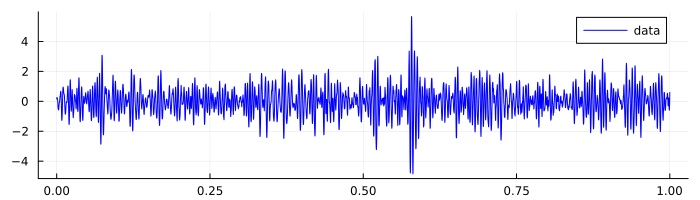

In [45]:
from = 1 
to = length(y_data)
skip = 1

plot(t_data,y_data,size = (700,200), color=:blue, label= "data")

In [54]:
#GP Amplitude Demodulation model 
@model function gp_AmplitudeDemodulation(n,P∞,A,Q,H)
    y = datavar(Float64,n)
    f = randomvar(n)
    z = randomvar(n)
    g = randomvar(n)
    c = randomvar(n)
    # w = randomvar(n)
    
    f_0 ~ MvNormalMeanCovariance(zeros(length(H)), P∞)
    f_prev = f_0
    for i=1:n 
        f[i] ~ MvNormalMeanCovariance(A[i] * f_prev, Q[i])
        z[i] ~ NormalMeanVariance(dot(H , f[i]), 0.01)

        g[i] ~ MyExponential(z[i]) 
        c[i] ~ NormalMeanPrecision(0.0,1.) 
        y[i] ~ (*)(c[i],g[i]) where {meta = TinyCorrection(), pipeline = RequireMessage(A = NormalMeanPrecision(0., 10.),in = LogNormal(0,4.))}

        f_prev = f[i]
    end
end

In [55]:
#### specify all hyperparameters
θ = [0.015, 1.]; # store [l, σ²]
Δt = [t_data[1]]; # time difference
append!(Δt, t_data[2:end] - t_data[1:end-1]);
# Δt = 0.0001 * ones(length(t_data))

λ = sqrt(5)/θ[1];
#### compute matrices for the state-space model corresponding to Matern-52 kernel ######
L = [0., 0., 1.];
H = [1., 0., 0.];
F = [0. 1. 0.; 0. 0. 1.;-λ^3 -3λ^2 -3λ]
Qc = 16/3 * θ[2] * λ^5;

Imat = diageye(3) ; 
vec_P = inv(kron(Imat,F) + kron(F,Imat)) * vec(-L * Qc * L'); 
P∞ = reshape(vec_P,3,3);
A = [exp(F * i) for i in Δt]; 
Q = [P∞ - i*P∞*i' for i in A];

In [56]:
nits =10

iresult = inference(
    model = gp_AmplitudeDemodulation(length(y_data), P∞,A,Q,H),
    iterations = nits, 
    data  = (y = y_data,),
    returnvars = (f = KeepLast(),),
    options = (limit_stack_depth=100,),
    showprogress = true
)

Progress:  20%|████████▎                                |  ETA: 0:02:50

Progress:  30%|████████████▎                            |  ETA: 0:02:33

Progress:  40%|████████████████▍                        |  ETA: 0:02:09

Progress:  50%|████████████████████▌                    |  ETA: 0:01:54

Progress:  60%|████████████████████████▋                |  ETA: 0:01:30

Progress:  70%|████████████████████████████▊            |  ETA: 0:01:06

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:43

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:21

Progress: 100%|█████████████████████████████████████████| Time: 0:03:31


Inference results:
  Posteriors       | available for (f)


In [57]:
mgp = mean.(iresult.posteriors[:f]) |> slicedim(1)
vgp = var.(iresult.posteriors[:f]) |> slicedim(1)
expvgp = exp.( mgp .+ vgp)
expmgp = exp.(mgp);

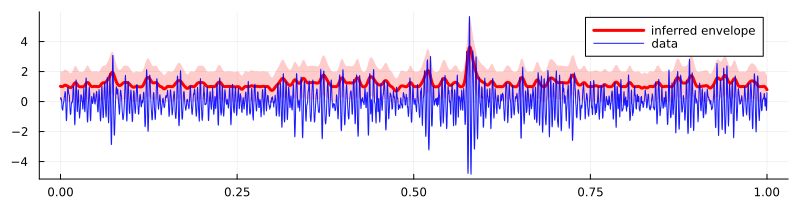

In [58]:
from = 1
to = length(y_data)
skip = 1
plot(t_data[from:skip:to],expmgp[from:skip:to],ribbon=sqrt.(expvgp),linewidth=3.0,label="inferred envelope",fillalpha=0.2,color=:red, size=(800,200))
plot!(t_data[from:skip:to],y_data[from:skip:to], label="data",alpha=0.9,ms=3, color=:blue)